In [5]:
if 'libraries_imported' not in globals():
    libraries_imported = False

if libraries_imported == False:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta
    from datetime import datetime
    from scipy.interpolate import make_interp_spline
    import plotly.graph_objects as go
    from scipy.signal import butter, filtfilt
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    from tensorflow.keras.layers import Input
    import sys
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import RobustScaler
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from sklearn.preprocessing import RobustScaler
    import joblib









In [6]:
df_cook = pd.read_csv('cook_data_cleaned.csv')
df_hepworth = pd.read_csv('hepworth_data_cleaned.csv')


datasets = [df_cook, df_hepworth]
names = ['dt_cook_interp', 'df_hepworth_interp']  # Names for the interpolated DataFrames
datasets_interpolated = {}  # Use a dictionary to store dataframes with specific names

for data, name in zip(datasets, names):
    # Convert the 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])
    # Set the 'date' column as the index
    data.set_index('date', inplace=True)
    # Perform forward-fill interpolation
    data.interpolate(method='ffill', inplace=True)
    # Reset the index
    data.reset_index(inplace=True)
    # Assign the modified DataFrame to the dictionary with a specific name
    datasets_interpolated[name] = data.copy()

# Now you can access the interpolated DataFrames by their names
dt_cook_interp = datasets_interpolated['dt_cook_interp']
df_hepworth_interp = datasets_interpolated['df_hepworth_interp']




# df_hepworth = df_hepworth[enhanced_features]
# df_cook = df_cook[enhanced_features]
    

scaler_path = 'robust_scaler.joblib'
scaler = joblib.load(scaler_path)


print(datasets_interpolated)


{'dt_cook_interp':           date  t1_ph     h2s_ppm  biogas_vol     t1_olr  methane_percentage  \
0   2024-11-04   7.00  664.000000       300.0   2.992500            0.666600   
1   2024-11-05   7.00  650.000000       690.0   2.355000            0.627100   
2   2024-11-06   7.00  634.000000       660.0   2.002500            0.641600   
3   2024-11-07   7.00  538.000000       770.0   2.062500            0.613200   
4   2024-11-08   7.00  522.000000       740.0   2.467500            0.606100   
..         ...    ...         ...         ...        ...                 ...   
117 2025-03-07   7.07  291.000000      2340.0   9.301838            0.642700   
118 2025-03-08   7.07  335.511628      3070.0  10.630237            0.634733   
119 2025-03-09   7.07  423.000000      3140.0  10.902600            0.619075   
120 2025-03-10   6.90  467.000000      2960.0   9.711575            0.611200   
121 2025-03-11   6.90  467.000000      3190.0   9.960400            0.611200   

      eq_cod   t1_co

/tmp/ipykernel_13099/3897562047.py:15: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.interpolate(method='ffill', inplace=True)
/tmp/ipykernel_13099/3897562047.py:15: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.interpolate(method='ffill', inplace=True)


In [7]:


np.random.seed(43)
tf.random.set_seed(43)
scaler_path = 'robust_scaler.joblib'
scaler = joblib.load(scaler_path)
# Load pre-trained model
model_path = 'best_model_fold_4.keras'
model = tf.keras.models.load_model(model_path)

# Make only the last few layers trainable
for layer in model.layers[:-2]:
    layer.trainable = False
for layer in model.layers[-2:]:
    layer.trainable = True


data = datasets_interpolated['dt_cook_interp']
features = data.drop(['fostac', 'date'], axis=1)
targets = data['fostac']
dates = data['date']





# Determine indices for manual split
num_samples = len(features)
half_point = num_samples // 2

# Initialize variables to collect results
true_values = []
predicted_values = []
prediction_dates = []

# Setup Early Stopping and Reduce LR callbacks
early_stopping = EarlyStopping(monitor='mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='mae', factor=0.2, patience=5)
import numpy as np

# Loop over the dataset twice to switch training and validation sets
for i in range(2):  # Two iterations
    if i == 0:
        train_index = np.arange(0, half_point)
        val_index = np.arange(half_point, num_samples)
    else:
        train_index = np.arange(half_point, num_samples)
        val_index = np.arange(0, half_point)

    # Randomly select 5 indices from each half to add to the other half
    random_indices_from_train = np.random.choice(train_index, 10, replace=False)
    random_indices_from_val = np.random.choice(val_index, 10, replace=False)

    # Add these indices to the opposing set
    train_index = np.concatenate((train_index, random_indices_from_val))
    val_index = np.concatenate((val_index, random_indices_from_train))

    # Ensure validation set does not include the new train indices
    val_index = np.setdiff1d(val_index, random_indices_from_val)

    # Select the data for training and validation
    X_train, X_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = targets.iloc[train_index], targets.iloc[val_index]
    dates_train, dates_val = dates.iloc[train_index], dates.iloc[val_index]

    # Scaling
    scaler = joblib.load(scaler_path)
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Fit the model
    model.fit(X_train_scaled, y_train, epochs=130, batch_size=4,
              validation_data=(X_val_scaled, y_val), callbacks=[early_stopping, reduce_lr])

    # Predict only on validation sets
    val_predictions = model.predict(X_val_scaled).flatten()

    # Collect results for plotting
    true_values.extend(y_val.tolist())
    predicted_values.extend(val_predictions.tolist())
    prediction_dates.extend(dates_val.tolist())

# Continue with sorting and plotting


# Sort all by dates for consistent plotting
sorted_indices = np.argsort(prediction_dates)
sorted_dates = np.array(prediction_dates)[sorted_indices]
sorted_true_values = np.array(true_values)[sorted_indices]
sorted_predicted_values = np.array(predicted_values)[sorted_indices]

Epoch 1/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2113 - mae: 0.2113 - val_loss: 0.1082 - val_mae: 0.1082 - learning_rate: 0.0013
Epoch 2/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0757 - mae: 0.0757 - val_loss: 0.1023 - val_mae: 0.1023 - learning_rate: 0.0013
Epoch 3/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0619 - mae: 0.0619 - val_loss: 0.0937 - val_mae: 0.0937 - learning_rate: 0.0013
Epoch 4/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0678 - mae: 0.0678 - val_loss: 0.1180 - val_mae: 0.1180 - learning_rate: 0.0013
Epoch 5/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0555 - mae: 0.0555 - val_loss: 0.1145 - val_mae: 0.1145 - learning_rate: 0.0013
Epoch 6/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0510 - mae: 0.0510 - val_loss: 0.1817 - val_mae: 0.1817 - learning_rate: 0.0013
Epoch 7/130
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0619 - mae: 0.0619 - val_loss: 0.1424 - val_mae: 0.1424 - learning_rate: 0.0013
Epoch 8/130


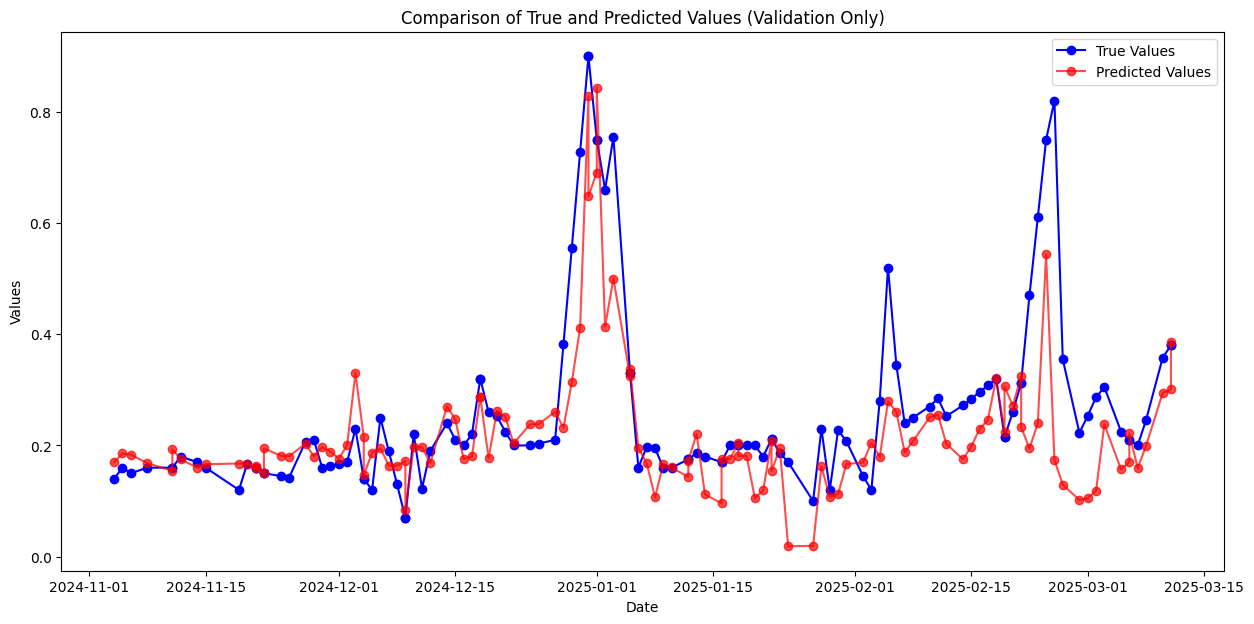

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(sorted_dates, sorted_true_values, label='True Values', color='blue', marker='o', linestyle='-')
plt.plot(sorted_dates, sorted_predicted_values, label='Predicted Values', alpha=0.7, color='red', marker='o', linestyle='-')
plt.legend()
plt.title('Comparison of True and Predicted Values (Validation Only)')
plt.xlabel('Date')
plt.ylabel('Values')

# Show the plot
plt.show()